In [2]:
# Dataset
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
# Prepare the dataset
df = pd.read_csv("data/car_fuel_efficiency.csv")
df = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


array([[<Axes: title={'center': 'fuel_efficiency_mpg'}>]], dtype=object)

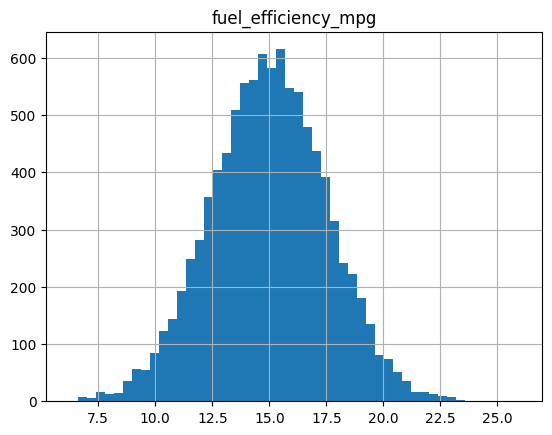

In [ ]:
# EDA: the target variable is not long-tailed
df[['fuel_efficiency_mpg']].hist(bins=50)

In [10]:
# Q1
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [11]:
df.describe()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
count,9704.000000,8996.000000,9704.000000,9704.000000,9704.000000
mean,199.708368,149.657292,3001.280993,2011.484027,14.985243
std,49.455319,29.879555,497.894860,6.659808,2.556468
min,10.000000,37.000000,952.681761,2000.000000,6.200971
25%,170.000000,130.000000,2666.248985,2006.000000,13.267459
50%,200.000000,149.000000,2993.226296,2012.000000,15.006037
75%,230.000000,170.000000,3334.957039,2017.000000,16.707965
max,380.000000,271.000000,4739.077089,2023.000000,25.967222


In [136]:
# Prepare and split the dataset
N = df.shape[0]
idx = np.arange(N)
np.random.seed(42)
np.random.shuffle(idx)
idx[:5]

array([ 483, 7506, 8795, 1688, 6217])

In [138]:
df = df.iloc[idx]
size_20 = int(N * 0.2)
size_train = N - size_20 * 2
df_train = df.iloc[: size_train]
df_val = df.iloc[size_train: (size_train + size_20)]
df_test = df.iloc[-size_20:]
print(len(df_train), len(df_val), len(df_test))
print(N, len(df_train) + len(df_val) + len(df_test))

5824 1940 1940
9704 9704


In [161]:
# Q3
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
def prepare_X(df):
    df = df[cols].fillna(0)
    X = df.values
    return X

def train_linear_regression(X, y):
    # X, y: np.ndarray
    n_rows = len(y)
    X = np.column_stack([np.ones(n_rows), X])
    XTX_inv = np.linalg.inv(X.T @ X)
    W = XTX_inv @ X.T @ y
    return W[0], W[1:]

def predict(X, w0, w):
    return w0 + X.dot(w)

def rmse(y_pred, y_true):
    mse = np.mean((y_pred - y_true) ** 2)
    return np.sqrt(mse).round(3)

In [140]:
y = df_train["fuel_efficiency_mpg"].values
y_val = df_val["fuel_efficiency_mpg"].values

In [141]:
# Fill missing with 0
X_fill_zero = prepare_X(df_train)
w0, w = train_linear_regression(X_fill_zero, y)

X_val_fill_zero = prepare_X(df_val)
y_val_pred = predict(X_val_fill_zero, w0, w)
print(rmse(y_val_pred, y_val))

0.52


In [142]:
# Fill missing with mean
hp_mean = df_train["horsepower"].mean()

X_fill_mean = df_train[cols].copy()
X_fill_mean = X_fill_mean.fillna({"horsepower": hp_mean})
w0, w = train_linear_regression(X_fill_mean, y)

X_val_fill_mean = df_val[cols].copy()
X_val_fill_mean.fillna({"horsepower": hp_mean}, inplace=True)

y_val_pred = predict(X_val_fill_mean, w0, w)
print(rmse(y_val_pred, y_val))

0.46


<Axes: ylabel='Count'>

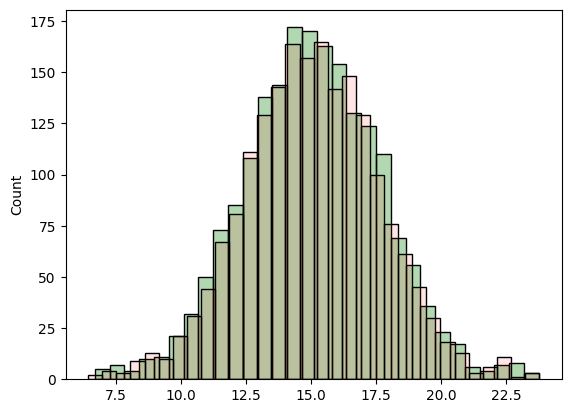

In [143]:
sns.histplot(y_val, color="green", alpha=0.3)
sns.histplot(y_val_pred, color="red", alpha=0.1)

In [144]:
# Q4

def train_linear_regression_reg(X, y, r):
    # X, y: np.ndarray
    n_rows = len(y)
    X = np.column_stack([np.ones(n_rows), X])
    XTX = X.T @ X
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    W = XTX_inv @ X.T @ y
    return W[0], W[1:]

In [157]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X, y, r)

    X_val = prepare_X(df_val)
    y_val_pred = predict(X_val, w0, w)
    
    print(r, rmse(y_val_pred, y_val))

0 0.53
0.01 0.53
0.1 0.53
1 0.54
5 0.54
10 0.54
100 0.54


In [158]:
# Q5
stds = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(idx)
    print(idx[:5])
    df = df.iloc[idx]
    size_20 = int(N * 0.2)
    size_train = N - size_20 * 2
    df_train = df.iloc[: size_train]
    # print(df_train.head(1))
    df_val = df.iloc[size_train: (size_train + size_20)]
    # df_test = df.iloc[-size_20:]
    
    print(f"-- Seed: {seed}")
    # print(len(df_train), len(df_val), len(df_test))
    # print(N, len(df_train) + len(df_val) + len(df_test))
    
    X = prepare_X(df_train)
    # print(X[:1])
    y = df_train["fuel_efficiency_mpg"].values
    w0, w = train_linear_regression(X, y)
    
    y_val = df_val["fuel_efficiency_mpg"].values
    X_val = prepare_X(df_val)
    y_val_pred = predict(X_val, w0, w)
    score = rmse(y_val_pred, y_val)
    print(score)
    
    stds.append(score)
    
print(np.std(stds).round(3))


[6146 3410  272 7044 6730]
-- Seed: 0
0.53
[2754 3802 1432 9088 9280]
-- Seed: 1
0.53
[ 246 8125 1927 8235  424]
-- Seed: 2
0.52
[ 433 3584 5104 2431 1048]
-- Seed: 3
0.54
[2159 8043  603 4028 6785]
-- Seed: 4
0.52
[5607 5858 7722 7623 3596]
-- Seed: 5
0.51
[6898   56 8384 7620 5381]
-- Seed: 6
0.52
[9588 2811 9057 3529 7859]
-- Seed: 7
0.52
[6918 7384 1908 5148  867]
-- Seed: 8
0.52
[9066 3073 2476  658  954]
-- Seed: 9
0.52
0.008


In [164]:
# Q6

idx = np.arange(N)
np.random.seed(9)
np.random.shuffle(idx)
print(idx[:5])

df = df.iloc[idx]
size_20 = int(N * 0.2)
size_train = N - size_20 * 2
df_train = df.iloc[: size_train]
# print(df_train.head(1))
df_val = df.iloc[size_train: (size_train + size_20)]
df_test = df.iloc[-size_20:]

# Merge val into train
df_train = pd.concat([df_train, df_val], axis = 0)

X = prepare_X(df_train)
# print(X[:1])
y = df_train["fuel_efficiency_mpg"].values
w0, w = train_linear_regression_reg(X, y, r=0.01)

y_test = df_test["fuel_efficiency_mpg"].values
X_test = prepare_X(df_test)
y_test_pred = predict(X_test, w0, w)
score = rmse(y_test_pred, y_test)
print(score)

[9066 3073 2476  658  954]
0.516
